In [2]:
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

In [2]:
# prod_entry = pd.read_csv('Данные о вводе товаров в оборот с 2021-11-22 по 2022-11-21.csv')
# point_reference = pd.read_csv('Справочник торговых точек.csv')
# prod_with = pd.read_csv('closed.csv')

In [3]:
# prod_entry_cnt = prod_entry.groupby('gtin', as_index=False).agg({'cnt' : 'sum'}).rename(columns={'cnt' : 'consumption'})
# prod_with_cnt = prod_with.groupby('gtin', as_index=False).agg({'cnt' : 'sum'})

In [4]:
# top_100_gtin = prod_with_cnt.merge(prod_entry_cnt, on='gtin', how='inner').sort_values('consumption')[-100:].gtin

# top_100_prod_with = prod_with[prod_with.gtin.isin(top_100_gtin)]

In [5]:

# inn_reg = dict(zip(point_reference.inn, point_reference.region_code))
# top_100_prod_with['reg_id'] = top_100_prod_with['inn'].map(inn_reg).dropna().astype('int')

In [7]:
# top_100_prod_with.to_csv('filtered_100.csv', index=False)

In [2]:
def demand(df, interval='month'):
    if interval == 'month':
        df['dt_d'] = df.dt.apply(lambda x: f'{x.year}.{x.month}')
    else:
        df['dt_d'] = df.dt.apply(lambda x: f'{x.year}.{x.week}')
    grouped = df.groupby(['gtin', 'type_operation', 'reg_id', 'dt_d'], as_index=False).agg({'cnt' : 'sum', 'dt': 'max'})
    return grouped[['gtin', 'type_operation', 'reg_id', 'cnt', 'dt']]

In [3]:
# prod_entry = pd.read_csv('Данные о вводе товаров в оборот с 2021-11-22 по 2022-11-21.csv')
# point_reference = pd.read_csv('Справочник торговых точек.csv')

In [4]:
# top_1000_prod_with = pd.read_csv('filtered_100.csv').dropna()
# top_1000_prod_with.reg_id = top_1000_prod_with.reg_id.astype('int')

In [5]:
# sold_names = ['Продажа конечному потребителю в точке продаж', 
#  'Дистанционная продажа конечному потребителю', 
#  'Конечная продажа организации', 
#  'Продажи за пределы РФ', 
#  'Продажа по государственному контракту']
# write_off = ['Списание / Вывод из оборота без получателя', 'Прочий тип вывода из оборота']

# closed_gtin = top_1000_prod_with.copy()
 
# closed_gtin.type_operation = closed_gtin.type_operation.apply(lambda x: 'sold' if x in sold_names else 'write_off')
# closed_gtin.dt = pd.to_datetime(top_1000_prod_with.dt)

In [6]:
df = demand(closed_gtin, interval= 'week')

In [3]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size)) # (num_layers * num_directions, batch_size, hidden_size)

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [4]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [3]:
flight_data = pd.read_csv('week_closed_gtin.csv')
flight_data = flight_data[flight_data['type_operation'] == 'sold']

In [17]:
flight_data

,gtin,type_operation,reg_id,cnt,dt
0,00C22971781D72C7C475869EC049959A,sold,2,2,2021-11-27
1,00C22971781D72C7C475869EC049959A,sold,2,8,2021-12-05
2,00C22971781D72C7C475869EC049959A,sold,2,10,2021-12-12
3,00C22971781D72C7C475869EC049959A,sold,2,11,2021-12-19
4,00C22971781D72C7C475869EC049959A,sold,2,10,2021-12-26
...,...,...,...,...,...
855721,FFFA84FC6402E3B4EBD9EBC8865A99BD,sold,92,1,2022-06-25
855722,FFFA84FC6402E3B4EBD9EBC8865A99BD,sold,92,2,2022-09-03
855723,FFFA84FC6402E3B4EBD9EBC8865A99BD,sold,92,1,2022-09-15
855724,FFFA84FC6402E3B4EBD9EBC8865A99BD,sold,92,1,2022-10-12


In [8]:
q = flight_data.groupby(['gtin', 'reg_id'], as_index=False).agg({'dt' : 'count', 'cnt' : 'sum'})
q = q[q.dt > 12]

In [18]:
qww = flight_data[flight_data.gtin.isin(q.groupby('gtin').cnt.sum().sort_values()[-100:].index.to_list())]

In [22]:
qww.to_csv('new_week_closed_gtin.csv', index=False)

In [19]:
qww[['gtin', 'reg_id']].drop_duplicates()

,gtin,reg_id
17398,064592BF672D421BBDAE2BA0C506877B,2
17452,064592BF672D421BBDAE2BA0C506877B,16
17506,064592BF672D421BBDAE2BA0C506877B,37
17549,064592BF672D421BBDAE2BA0C506877B,45
17551,064592BF672D421BBDAE2BA0C506877B,47
...,...,...
838717,F6E8A4B5265B825326B8A2DA71DE04C6,78
838722,F6E8A4B5265B825326B8A2DA71DE04C6,83
838730,F6E8A4B5265B825326B8A2DA71DE04C6,86
838734,F6E8A4B5265B825326B8A2DA71DE04C6,91


In [20]:
qww.reg_id.value_counts()

77    4169
58    2683
66    2479
78    2437
24    2150
      ... 
4       91
87      59
8       35
17      21
6       16
Name: reg_id, Length: 84, dtype: int64

In [26]:
flight_data[['gtin', 'reg_id']].drop_duplicates()

,gtin,reg_id
0,00C22971781D72C7C475869EC049959A,2
45,00C22971781D72C7C475869EC049959A,3
52,00C22971781D72C7C475869EC049959A,11
53,00C22971781D72C7C475869EC049959A,16
104,00C22971781D72C7C475869EC049959A,18
...,...,...
855657,FFFA84FC6402E3B4EBD9EBC8865A99BD,77
855711,FFFA84FC6402E3B4EBD9EBC8865A99BD,78
855712,FFFA84FC6402E3B4EBD9EBC8865A99BD,86
855713,FFFA84FC6402E3B4EBD9EBC8865A99BD,91


In [27]:
for idx, row in flight_data[['gtin', 'reg_id']].drop_duplicates().iterrows():
    print(row)
    break

gtin      00C22971781D72C7C475869EC049959A
reg_id                                   2
Name: 0, dtype: object


In [12]:
def get_data_by_reg_getin(df, gtin, reg_id):
    return df[(df.gtin == gtin) & (df.reg_id == reg_id)].sort_values('dt')

In [13]:
flight_data = get_data_by_reg_getin(flight_data, 'FC2186495AC107CB2BBBFF96D2DE6D71', 77)

In [14]:
flight_data

,gtin,type_operation,reg_id,cnt,dt
849079,FC2186495AC107CB2BBBFF96D2DE6D71,sold,77,175,2021-11-28
849080,FC2186495AC107CB2BBBFF96D2DE6D71,sold,77,7570,2021-12-05
849081,FC2186495AC107CB2BBBFF96D2DE6D71,sold,77,11864,2021-12-12
849082,FC2186495AC107CB2BBBFF96D2DE6D71,sold,77,9886,2021-12-19
849083,FC2186495AC107CB2BBBFF96D2DE6D71,sold,77,4510,2021-12-26
849084,FC2186495AC107CB2BBBFF96D2DE6D71,sold,77,1882,2021-12-31
849128,FC2186495AC107CB2BBBFF96D2DE6D71,sold,77,145,2022-01-02
849085,FC2186495AC107CB2BBBFF96D2DE6D71,sold,77,1061,2022-01-09
849096,FC2186495AC107CB2BBBFF96D2DE6D71,sold,77,956,2022-01-16
849107,FC2186495AC107CB2BBBFF96D2DE6D71,sold,77,457,2022-01-23


In [15]:
all_data = flight_data['cnt'].values.astype(float)

test_data_size = int(0.15 * len(all_data))

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = torch.FloatTensor(scaler.fit_transform(train_data.reshape(-1, 1))).view(-1)

train_window = int(0.15 * len(all_data))

In [16]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

epochs = 17

model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.03472045
epoch:  16 loss: 0.0096124699


In [4]:
import numpy as np

In [5]:
ex = np.array([[1, 2 , 3, 4]])

In [6]:
ex[:, 1:] += 1
ex

array([[1, 3, 4, 5]])

In [17]:
fut_pred = 8

test_inputs = train_data_normalized[-8:].tolist()

In [20]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
test_inputs = [abs(min(test_inputs)) + i for i in test_inputs]

actual_predictions = scaler.inverse_transform(np.array(test_inputs[-8:]).reshape(-1, 1))

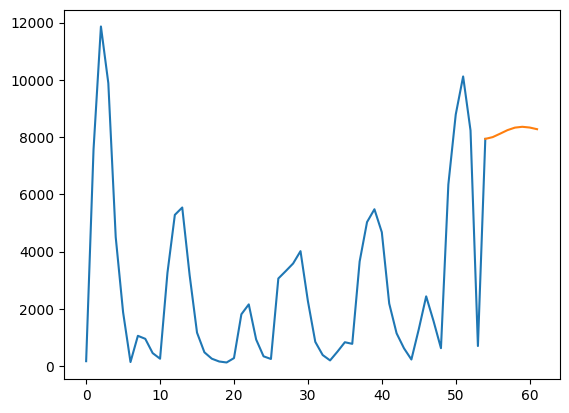

In [21]:
previous = np.concatenate((flight_data['cnt'].values, [actual_predictions[0][0]]))
plt.plot(previous)
plt.plot(np.arange(len(all_data), len(all_data) + 8, 1), actual_predictions)
plt.show()